<font size="+6"><h1><center>Data Cleaning</center></h1></font>

# Imports

In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Reading in Data

In [ ]:
#TODO: put all the data cleaning BEFORE this stuff here

In [35]:
energy_df = pd.read_csv('./Cleaning/energy_data.csv', index_col=0)
new_sp_df = pd.read_csv('./Cleaning/sp500_news_data.csv', index_col=0)
gold_df = pd.read_csv('./Cleaning/daily_gold_rate.csv')
pattern_df = pd.read_csv('./Cleaning/candlestick_patterns.csv', index_col=0)

In [ ]:
energy_df.head()

In [ ]:
new_sp_df.head()

In [ ]:
gold_df.head()

In [ ]:
pattern_df.head()

In [37]:
energy_df.rename(columns={"Date": "date"},inplace=True)
energy_df.columns

Index(['date', 'NY_cgas', 'US_cgas', 'WTI_crude_oil', 'NY_hoil'], dtype='object')

In [38]:
#NOTE: I'm adding an "average" column to use for data visualization (since I didn't want the pairplot to
#have Open, high, low, close. I just wanted one average to summarize these four variables to avoid
#the pairplot from getting too crowded). I'm not sure if the average is the same as the calculation before
#the standardizer we used but I think it should be fine since it's a linear transformation.

temp = []
for i in range(len(new_sp_df)):
    avg = (new_sp_df['High'][i] + new_sp_df['Low'][i])/2
    temp.append(avg)
    
new_sp_df['Average'] = temp
new_sp_df.head()

,date,Open,High,Low,Close,Volume,up/down,Sentiment,true_value,Average
0,1980-01-02,-1.157349,-1.064447,-1.065108,-1.066003,-0.960949,1.0,-0.632982,-1.0,-1.064778
1,1980-01-03,-1.157349,-1.066807,-1.067169,-1.066548,-0.955609,1.0,-0.547975,1.0,-1.066988
2,1980-01-07,-1.157349,-1.065080,-1.064590,-1.064943,-0.958844,1.0,-0.766564,1.0,-1.064835
3,1980-01-08,-1.157349,-1.063584,-1.064093,-1.062783,-0.954035,1.0,-1.139702,1.0,-1.063838
4,1980-01-09,-1.157349,-1.061777,-1.061940,-1.062682,-0.947613,1.0,-1.267481,1.0,-1.061858


In [39]:
#only USD
gold_df = gold_df[['Date','USD']]
gold_df.columns

Index(['Date', 'USD'], dtype='object')

In [40]:
#rename columm
gold_df.rename(columns = {'Date':'date'}, inplace = True)
gold_df.columns

Index(['date', 'USD'], dtype='object')

In [41]:
from sklearn.preprocessing import StandardScaler

#normalize data using sklearn
normalizer = StandardScaler()
df_dropped = gold_df.drop('date', axis = 1)
normalizer_gold_df = pd.DataFrame(normalizer.fit_transform(df_dropped), columns = df_dropped.columns)
normalizer_gold_df.insert(loc = 0, column = 'date', value = gold_df['date'])
normalizer_gold_df

,date,USD
0,1985-01-01,-0.878967
1,1985-01-02,-0.884399
2,1985-01-03,-0.890607
3,1985-01-04,-0.888958
4,1985-01-07,-0.898463
...,...,...
9754,2022-05-23,2.123904
9755,2022-05-24,2.145050
9756,2022-05-25,2.106444
9757,2022-05-26,2.108481


In [42]:
#merge data
df_names = [energy_df,new_sp_df,normalizer_gold_df,pattern_df]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['date'],
                                            how='outer'), df_names)

In [43]:
#drop NAN rows
df_merged = df_merged.dropna().reset_index(drop=True)
df_merged
#save dataframe
df_merged.to_csv('cleaned_data.csv')

In [44]:
df = pd.read_csv('cleaned_data.csv',index_col=0)
df.head()

,date,NY_cgas,US_cgas,WTI_crude_oil,NY_hoil,Open,High,Low,Close,Volume,...,CDLSHOOTINGSTAR_Bear,CDLSPINNINGTOP_Bear,CDLSPINNINGTOP_Bull,CDLSTICKSANDWICH_Bull,CDLTASUKIGAP_Bear,CDLTASUKIGAP_Bull,CDLTHRUSTING_Bear,CDLTRISTAR_Bear,CDLTRISTAR_Bull,NO_PATTERN
0,1986-06-02,0.468,0.445,13.80,0.402,-0.910826,-0.924568,-0.924449,-0.925426,-0.917674,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1986-06-03,0.436,0.418,13.35,0.393,-0.911828,-0.926807,-0.924611,-0.924952,-0.920866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1986-06-04,0.418,0.398,13.15,0.378,-0.911357,-0.926014,-0.925708,-0.926537,-0.919621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1986-06-05,0.431,0.415,13.21,0.390,-0.912930,-0.926657,-0.924875,-0.924811,-0.922921,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1986-06-06,0.421,0.403,12.73,0.385,-0.911217,-0.926245,-0.923840,-0.924791,-0.922921,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
df.columns

Index(['date', 'NY_cgas', 'US_cgas', 'WTI_crude_oil', 'NY_hoil', 'Open',
       'High', 'Low', 'Close', 'Volume', 'up/down', 'Sentiment', 'true_value',
       'Average', 'USD', 'CDL3INSIDE_Bear', 'CDL3INSIDE_Bull',
       'CDL3OUTSIDE_Bear', 'CDL3OUTSIDE_Bull', 'CDLBELTHOLD_Bear',
       'CDLBELTHOLD_Bull', 'CDLCLOSINGMARUBOZU_Bear',
       'CDLCLOSINGMARUBOZU_Bull', 'CDLDARKCLOUDCOVER_Bear', 'CDLDOJI_Bull',
       'CDLENGULFING_Bear', 'CDLENGULFING_Bull', 'CDLGAPSIDESIDEWHITE_Bear',
       'CDLGAPSIDESIDEWHITE_Bull', 'CDLHAMMER_Bull', 'CDLHANGINGMAN_Bear',
       'CDLHARAMI_Bear', 'CDLHARAMI_Bull', 'CDLHIGHWAVE_Bear',
       'CDLHIGHWAVE_Bull', 'CDLHIKKAKE_Bear', 'CDLHIKKAKE_Bull',
       'CDLHOMINGPIGEON_Bull', 'CDLINNECK_Bear', 'CDLINVERTEDHAMMER_Bull',
       'CDLLONGLEGGEDDOJI_Bull', 'CDLMATCHINGLOW_Bull', 'CDLONNECK_Bear',
       'CDLPIERCING_Bull', 'CDLRICKSHAWMAN_Bull', 'CDLSEPARATINGLINES_Bear',
       'CDLSEPARATINGLINES_Bull', 'CDLSHOOTINGSTAR_Bear',
       'CDLSPINNINGTOP_B

<font size="+6"><h1><center>Exploratory Data Analysis</center></h1></font>

In [ ]:
#see some basic statistics about our dataset
df.describe()

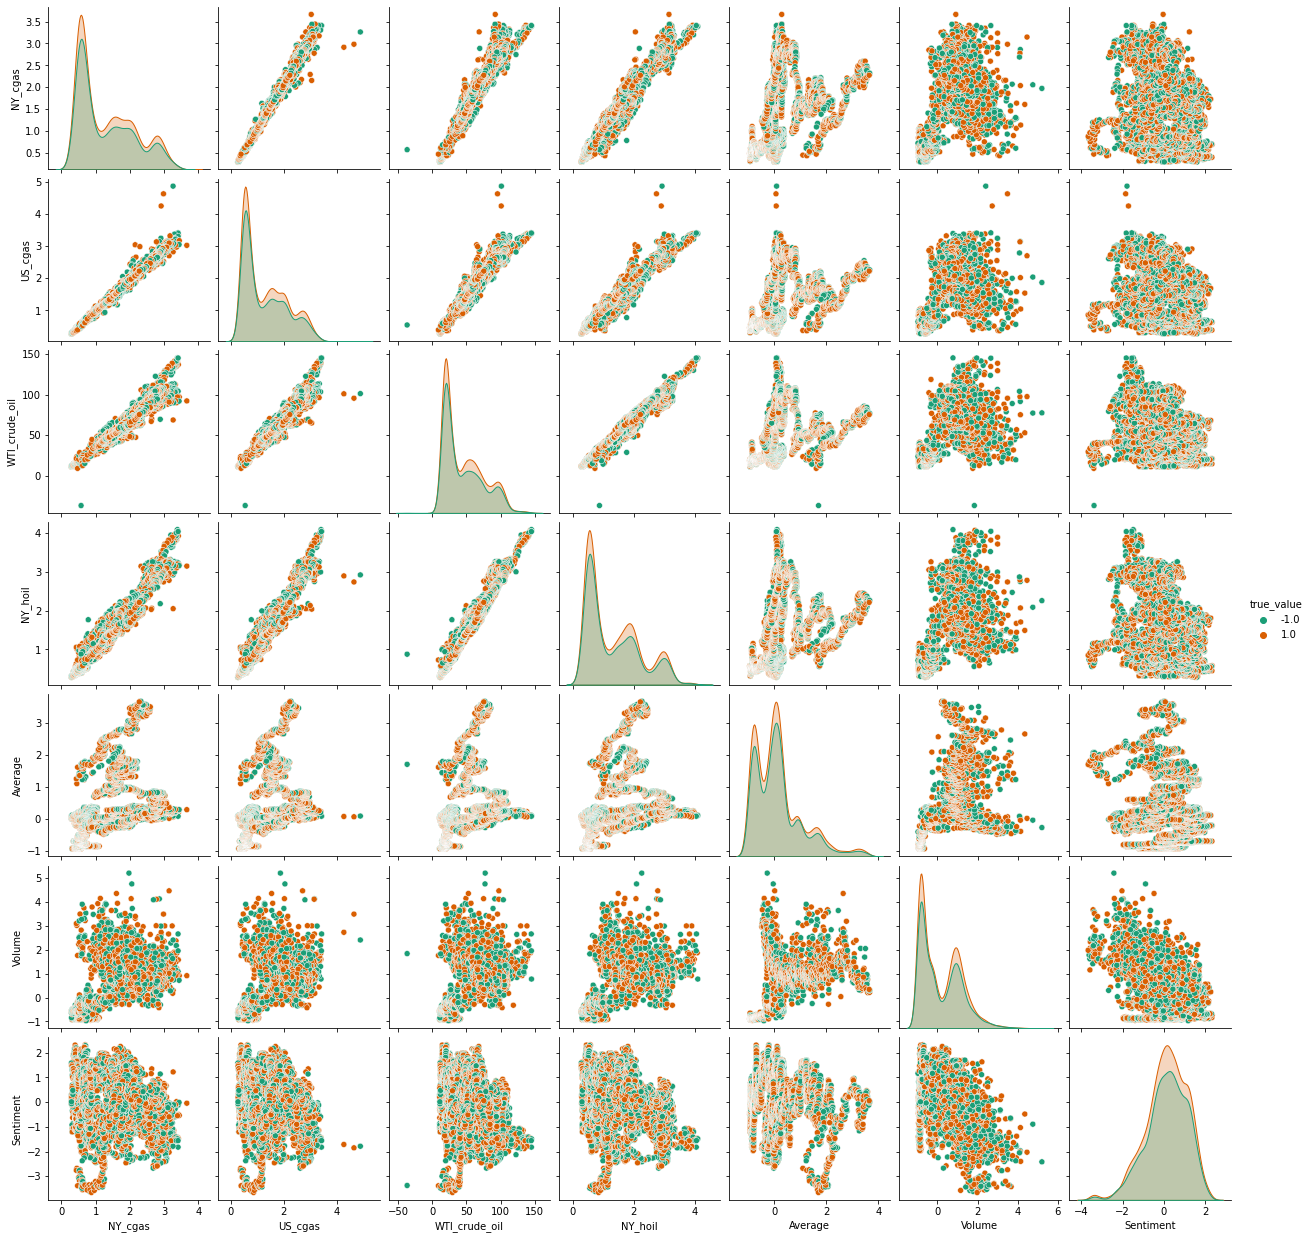

In [67]:
#these graphs show the correlation each variable has with one another
correlation_cols = df[['NY_cgas', 'US_cgas', 'WTI_crude_oil', 
                       'NY_hoil', 'Average', 'Volume', 'Sentiment', 'true_value']]
sns.pairplot(correlation_cols, hue="true_value", palette='Dark2')

In [69]:
y = df["true_value"]
X = df.loc[:, ['NY_cgas', 'US_cgas', 'WTI_crude_oil', 'NY_hoil', 'Open',
       'High', 'Low', 'Close', 'Volume', 'up/down', 'Sentiment', 'USD', 'CDL3INSIDE_Bear', 'CDL3INSIDE_Bull', 'CDL3OUTSIDE_Bear',
       'CDL3OUTSIDE_Bull', 'CDLBELTHOLD_Bear', 'CDLBELTHOLD_Bull',
       'CDLCLOSINGMARUBOZU_Bear', 'CDLCLOSINGMARUBOZU_Bull',
       'CDLDARKCLOUDCOVER_Bear', 'CDLDOJI_Bull', 'CDLENGULFING_Bear',
       'CDLENGULFING_Bull', 'CDLGAPSIDESIDEWHITE_Bear',
       'CDLGAPSIDESIDEWHITE_Bull', 'CDLHAMMER_Bull', 'CDLHANGINGMAN_Bear',
       'CDLHARAMI_Bear', 'CDLHARAMI_Bull', 'CDLHIGHWAVE_Bear',
       'CDLHIGHWAVE_Bull', 'CDLHIKKAKE_Bear', 'CDLHIKKAKE_Bull',
       'CDLHOMINGPIGEON_Bull', 'CDLINNECK_Bear', 'CDLINVERTEDHAMMER_Bull',
       'CDLLONGLEGGEDDOJI_Bull', 'CDLMATCHINGLOW_Bull', 'CDLONNECK_Bear',
       'CDLPIERCING_Bull', 'CDLRICKSHAWMAN_Bull', 'CDLSEPARATINGLINES_Bear',
       'CDLSEPARATINGLINES_Bull', 'CDLSHOOTINGSTAR_Bear',
       'CDLSPINNINGTOP_Bear', 'CDLSPINNINGTOP_Bull', 'CDLSTICKSANDWICH_Bull',
       'CDLTASUKIGAP_Bear', 'CDLTASUKIGAP_Bull', 'CDLTHRUSTING_Bear',
       'CDLTRISTAR_Bear', 'CDLTRISTAR_Bull', 'NO_PATTERN']]

In [70]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


## Base model: KNN

In [73]:
#run KNN
neighbor = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
score = neighbor.score(X_test, y_test)
print("Accuracy ", score)

Accuracy  0.6338315217391305


## Logistic Regression

In [72]:
# select Logistic Regression as our model
clf = LogisticRegression(random_state=0, max_iter = 50000).fit(X_train, y_train)
y_pred = clf.predict(X_test)

# get the accuracy for our model
score = clf.score(X_test, y_test)
print("Accuracy ", score)

Accuracy  0.7102581521739131


              precision    recall  f1-score   support

        -1.0       0.93      0.42      0.57      1385
         1.0       0.65      0.97      0.78      1559

    accuracy                           0.71      2944
   macro avg       0.79      0.69      0.68      2944
weighted avg       0.78      0.71      0.68      2944



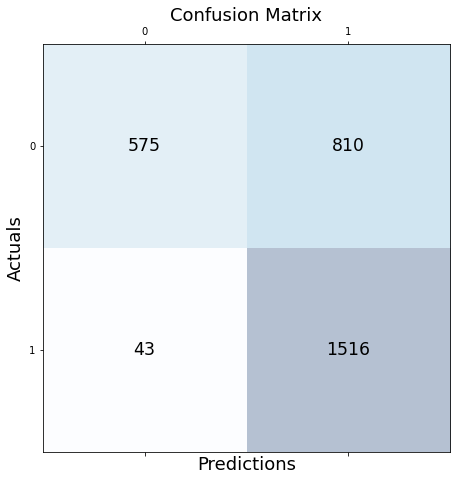

In [86]:
#code from: https://vitalflux.com/python-draw-confusion-matrix-matplotlib/

print(classification_report(y_test, y_pred))

# get and plot the confusion matrix for our model
conf_matrix = cm1
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large') 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Area under the Receiver Operating Characteristic curve: 0.7619509868169682


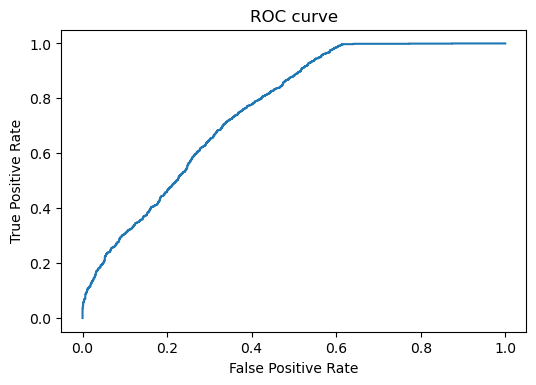

In [80]:
fpr = roc_curve(y_test, clf.predict_proba(X_test)[:,1])[0]  # false positive rate
tpr = roc_curve(y_test, clf.predict_proba(X_test)[:,1])[1]  # true positive rate
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

# get and plot the ROC curve for our model
plt.figure(dpi=100)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

print('Area under the Receiver Operating Characteristic curve:', 
      roc_auc)

In [81]:
# create a pipeline 
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# create search space of candidate learning algorithms and their hyperparameters
param_grid = [{'classifier': [LogisticRegression(max_iter=1000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=1000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=1000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]


# create grid search 
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), n_jobs = -1,
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0)

# fit grid search
best_model = clf.fit(X_train, y_train)

/Users/dzthai/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dzthai/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dzthai/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dzthai/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dzthai/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/dzthai/opt/anaconda3/lib/python3.9/sit

In [87]:
best_model.cv_results_

{'mean_fit_time': array([0.06037073, 0.13268476, 0.18113489, 0.1041976 , 0.41572428,
        0.30694613, 1.17902069, 1.48239856, 4.58350964, 4.20192499,
        5.81141334, 4.88479624, 6.63089895, 5.24515133, 7.33991432,
        5.77586284, 8.05403523, 6.01088881, 0.03100567, 0.04740543,
        0.06582146, 0.12216687, 0.2371304 , 0.45481787, 0.8303668 ,
        0.83856997, 0.67032275, 0.62840357, 3.01902399]),
 'std_fit_time': array([0.01562812, 0.00269572, 0.00498679, 0.01727129, 0.01824892,
        0.0236999 , 0.1727536 , 0.19850734, 0.57058642, 0.56658983,
        0.47703801, 0.15642635, 0.26123782, 0.16875934, 0.37914955,
        0.14746707, 0.21802041, 0.25394315, 0.00153812, 0.00492402,
        0.00568792, 0.01967456, 0.014888  , 0.03294862, 0.28057495,
        0.19372591, 0.06901558, 0.10316347, 0.08004978]),
 'mean_score_time': array([0.01364307, 0.01063762, 0.01284189, 0.01500955, 0.00891752,
        0.00856118, 0.00897532, 0.00881443, 0.01083817, 0.01107931,
        0.010273

In [88]:
# get the model with highest accuracy from grid search
p_accu = best_model.cv_results_['params'][np.argmin(best_model.cv_results_['rank_test_accuracy'])]
p_accu

{'classifier': LogisticRegression(max_iter=1000),
 'classifier__C': 0.001,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [89]:
clf = pipe.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score1 = clf.score(X_test, y_test)
print("The accuracy score for this model is", score1)

The accuracy score for this model is 0.7088994565217391


/Users/dzthai/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

        -1.0       0.92      0.42      0.57      1385
         1.0       0.65      0.97      0.78      1559

    accuracy                           0.71      2944
   macro avg       0.79      0.69      0.68      2944
weighted avg       0.78      0.71      0.68      2944



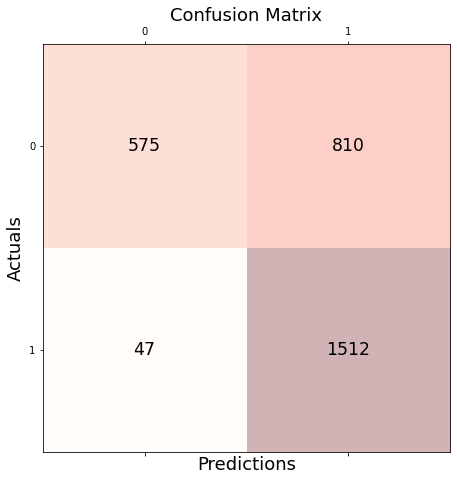

In [90]:
print(classification_report(y_test, y_pred))

cm2 = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm2, cmap=plt.cm.Reds, alpha=0.3)
for i in range(cm2.shape[0]):
    for j in range(cm2.shape[1]):
        ax.text(x=j, y=i,s=cm2[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Area under the Receiver Operating Characteristic curve: 0.7610228717381085


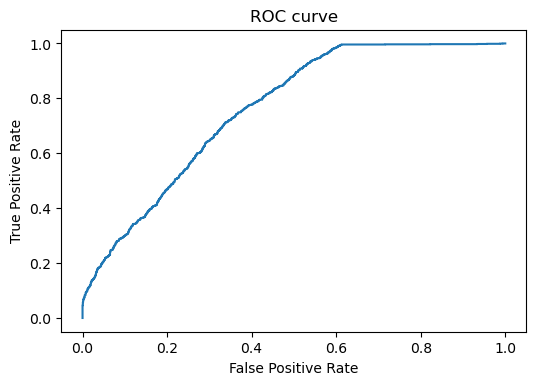

In [91]:
fpr = roc_curve(y_test, clf.predict_proba(X_test)[:,1])[0]  # false positive rate
tpr = roc_curve(y_test, clf.predict_proba(X_test)[:,1])[1]  # true positive rate
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

# plotting the ROC curve
plt.figure(dpi=100)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

print('Area under the Receiver Operating Characteristic curve:', 
      roc_auc)